# `fastprop` Demo Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jacksonburns/fastprop/blob/main/fastprop_demo.ipynb)

This notebook show you how to run `fastprop` on some benchmark datasets!
The results of running this notebook have been saved in-line, so you can scroll through without executing.
To get the best feel for `fastprop`, we do recommend running the cells for yourself!

When running, make sure you click **Runtime>Change Runtime Type** and select T4 GPU.
This will give you access to a GPU that will *dramatically* speed up the neural network training.

## Installation
This block shows the basic installation steps for `fastprop`, in this case installing from source by first cloning the GitHub repository.
You could also install from `pip` using `pip install fastprop[hopt,shap]` but this demo uses some of the benchmarks included in the repository (and not the PyPI package).

You can re-run this cell at any point in the future to 'reset' this demo.

In [1]:
%%capture
%cd /content
# remove existing code, if it exists
!rm -rf fastprop || true
!git clone https://github.com/JacksonBurns/fastprop
%cd /content/fastprop
!pip install .[hopt,shap]
# for showing the repository layout
!sudo apt-get install tree

## Demo Polycyclic Aromatic Hydrocarbons (PAH)
The GitHub repository for `fastprop` include a number of benchmarks, one of which is the PAH dataset.
This one includes the needed input data in the repostory, so we can run it straight out of the box!

### Preparing Your Data

Let's start by looking at what the input files are to `fastprop`:

In [2]:
%cd /content/fastprop/benchmarks
!tree pah

/content/fastprop/benchmarks
pah
├── arockiaraj_pah_data.csv
├── chemprop_pah.sh
└── pah.yml

0 directories, 3 files


The `pah.yml` and `arockiaraj_pah_data.csv` files are the configuration files used for `fastprop`, and `chemprop_pah.sh` is a script to run Chemprop on the same dataset (try this out on your own later!).

The data should be in a CSV file that looks something like this:

In [3]:
!head -n 4 pah/arockiaraj_pah_data.csv

compound,smiles,log_p,retention_index,boiling_point_c,acentric_factor
Anthanthrene,C1=CC2=C3C(=C1)C=C4C=CC5=C6C4=C3C(=CC6=CC=C5)C=C2,7.04,3215,497.1,
Anthracene,C1=CC=C2C=C3C=CC=CC3=CC2=C1,4.45,1804,337.4,0.477
Benzene,C1=CC=CC=C1,2.04,979,80,0.21


Note that there is one column that contains the SMILES string, and then a number of columns containing target values for each of the SMILES. You can call all columns anything _without spaces_, and there can be any number of them.

Now, the configuration file:

In [4]:
!cat pah/pah.yml

# The Polycyclic Aromatic Hydrocarbon (PAH) Dataset, as described in:
# https://doi.org/10.1080/1062936X.2023.2239149
#
# The reference study did not include a digitized version of their dataset,
# so I have included one here that I curated manually. All that was done
# was to look up the SMILES strings for the PAHs, using either OPSIN (via
# py22opsin), PubChem, or ChemSpider.
#
# Additional Comments:
# 

# generic args
output_directory: pah
random_seed: 562
problem_type: regression

# featurization
input_file: pah/arockiaraj_pah_data.csv
target_columns: log_p
smiles_column: smiles
descriptor_set: all

# training
hidden_size: 128
fnn_layers: 2
number_repeats: 1
number_epochs: 20
batch_size: 64
patience: 5
train_size: 0.8
val_size: 0.1
test_size: 0.1
sampler: random


All of the configuration options for `fastprop` can be specified in this file.
Most important are the name of the column containing the SMILES string, and the name of the column (or columns, separate by a space) of the targets.

For more information on each of the other options, check the [`fastprop` README](https://github.com/JacksonBurns/fastprop).

Now we can train the model!

In [5]:
!fastprop train pah/pah.yml

Seed set to 562
[04/19/2024 07:32:02 PM fastprop.descriptors] INFO: Calculating descriptors
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100% 55/55 [01:53<00:00,  2.06s/it]
[04/19/2024 07:33:56 PM fastprop.descriptors] INFO: Descriptor calculation complete, elapsed time: 0:01:53.434715
[04/19/2024 07:33:56 PM fastprop.descriptors] INFO: Cached descriptors to pah/cached_arockiaraj_pah_data_all_1713554970.csv
[04/19/2024 07:33:56 PM fastprop.cli.train] INFO: Run 'tensorboard --logdir pah/tensorboard_logs' to track training progress.
[04/19/2024 07:33:56 PM fastprop.cli.train] INFO: Training model 1 of 1 (random_seed=562)
/usr/local/lib/python3.10/dist-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested validation size of 0.10, got 0.11.

### Output from `fastprop train`
Let's look at the `pah` directory to see what file we ended up with:

In [6]:
!tree pah

pah
├── arockiaraj_pah_data.csv
├── cached_arockiaraj_pah_data_all_1713554970.csv
├── chemprop_pah.sh
├── fastprop_1713555122
│   ├── checkpoints
│   │   └── repetition-1-epoch=19-val_loss=0.00.ckpt
│   ├── fastprop_log.txt
│   └── tensorboard_logs
│       └── repetition_1
│           ├── events.out.tfevents.1713555240.1fb33fc37668.3606.0
│           ├── events.out.tfevents.1713555243.1fb33fc37668.3606.1
│           ├── events.out.tfevents.1713555243.1fb33fc37668.3606.2
│           └── hparams.yaml
└── pah.yml

4 directories, 10 files


First we have `cached_arockiaraj_data...csv` - after calculating the descriptors, `fastprop` caches them to a file.
This means that on subsequent runs (if `enable_cache: True`, which it is by default) `fastprop` can reload them rather than spending the time calculating them again.

All of the outpur from `fastprop` was also saved to a log file called `fastprop_log.txt` for future reference.

`fastprop` created an output directory inside `pah` called `fastprop_timestamp`, and within that placed directories for:
 - `checkpoints` used for prediction and feature importance analysis
 - `csv_logs` which contain all of the metrics for training, test, and validation through training in CSV format for easy analysis
 - `tensorboard_logs` which has the files `tensorboard` uses to show model performance during training.

For more information about `fastprop train`, see the `--help`:

In [7]:
!fastprop train --help

usage: fastprop train [-h] [-od OUTPUT_DIRECTORY] [-if INPUT_FILE]
                      [-tc TARGET_COLUMNS [TARGET_COLUMNS ...]] [-sc SMILES_COLUMN]
                      [-d DESCRIPTORS] [-ec ENABLE_CACHE] [-p PRECOMPUTED] [-op] [-fl FNN_LAYERS]
                      [-lr LEARNING_RATE] [-bs BATCH_SIZE] [-ne NUMBER_EPOCHS]
                      [-nr NUMBER_REPEATS] [-pt PROBLEM_TYPE] [-ns TRAIN_SIZE] [-vs VAL_SIZE]
                      [-ts TEST_SIZE] [-s SAMPLER] [-rs RANDOM_SEED] [-pc PATIENCE]
                      [config_file]

positional arguments:
  config_file           YAML configuration file

options:
  -h, --help            show this help message and exit
  -od OUTPUT_DIRECTORY, --output-directory OUTPUT_DIRECTORY
                        directory for fastprop output
  -if INPUT_FILE, --input-file INPUT_FILE
                        csv of SMILES and targets
  -tc TARGET_COLUMNS [TARGET_COLUMNS ...], --target-columns TARGET_COLUMNS [TARGET_COLUMNS ...]
                   

### Predicting with Your Model
After training is completed, you can run `fastprop predict` to make predictions.

In [8]:
!fastprop predict --help

usage: fastprop predict [-h] [-ss SMILES_STRINGS [SMILES_STRINGS ...] | -sf SMILES_FILE]
                        (-ds DESCRIPTOR_SET | -pd PRECOMPUTED_DESCRIPTORS) [-o OUTPUT]
                        checkpoints_dir

positional arguments:
  checkpoints_dir       directory of checkpoint file(s) for predictions

options:
  -h, --help            show this help message and exit
  -ss SMILES_STRINGS [SMILES_STRINGS ...], --smiles-strings SMILES_STRINGS [SMILES_STRINGS ...]
                        SMILES string(s) for prediction
  -sf SMILES_FILE, --smiles-file SMILES_FILE
                        file containing SMILES strings only
  -ds DESCRIPTOR_SET, --descriptor-set DESCRIPTOR_SET
                        descriptors to calculate (one of all, optimized, or debug)
  -pd PRECOMPUTED_DESCRIPTORS, --precomputed-descriptors PRECOMPUTED_DESCRIPTORS
                        precomputed descriptors
  -o OUTPUT, --output OUTPUT
                        output file for predictions (defaults to stdout

Now to make predictions using the model we just trained, we use this command which will load all of trained models are run inference on the SMILES string we pass in (napthalene):

_Note: If you run this notebook live, you will need to change the string of numbers after `fastprop_` to match your local run! Google colab should help you with an autofill suggestion._

In [11]:
!fastprop predict pah/fastprop_1713555122/checkpoints --smiles-strings c1c2ccccc2ccc1 -ds all

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100% 1/1 [00:00<00:00,  6.88it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100% 1/1 [00:00<00:00,  7.95it/s]

                  task_0  task_0_stdev
c1c2ccccc2ccc1  1.74838           0.0


### Feature Importance with SHAP
`fastprop` can also calculate the importance of the various molecular descriptors using SHAP.

In [12]:
!fastprop shap --help

usage: fastprop shap [-h] [-it IMPORTANCE_THRESHOLD]
                     checkpoints_dir cached_descriptors descriptor_set

positional arguments:
  checkpoints_dir       directory of checkpoint file(s) for SHAP analysis
  cached_descriptors    csv of calculated descriptors cached by fastprop
  descriptor_set        descriptors in the cache file (one of all, optimized, or debug)

options:
  -h, --help            show this help message and exit
  -it IMPORTANCE_THRESHOLD, --importance-threshold IMPORTANCE_THRESHOLD
                        [0-1] include top fraction of features, default 0.75


Since we have a huge number of input features, the `--importance-threshold` can be used to cut down on the number that are shown in the output plot.
This scalar value between 0 and 1 dicates how important a feature must be to be shown - for example, if you set it to 0.90 you are asking to include features that are at least 90% as important as the most important feature.

Let's try it on this dataset:

In [17]:
!fastprop shap pah/fastprop_1713555122/checkpoints pah/cached_arockiaraj_pah_data_all_1713554970.csv all -it 0.90

Calculating SHAP values for each model: 100% 1/1 [00:00<00:00,  5.02it/s]


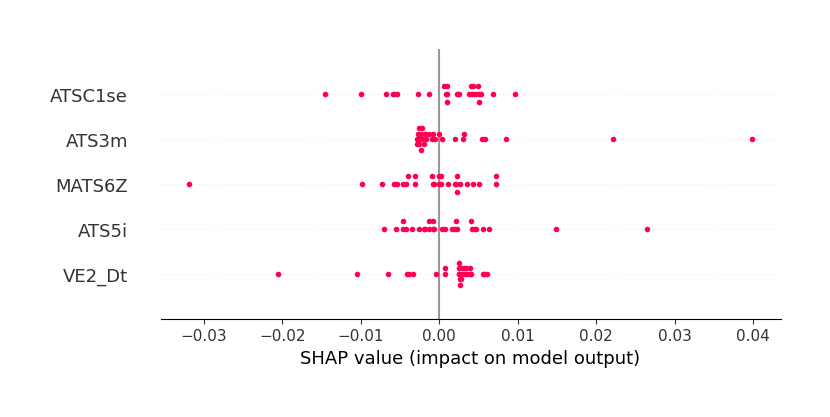

In [18]:
from IPython.display import Image
Image('task_0_feature_importance_beeswarm.png')

For small datasets like this one (55 points total) it can be difficult to parse a lot out of the SHAP analysis.
Coarsely, we can see that AATS-derived descriptors are the most important, and that they generally have a positive effect on the predicted partition coefficient.
For more information on which each of these descriptors means, check the documentation link printed in the log output.

This concludes the tutorial for `fastprop`.
Note that you can also use `fastprop` as a Python module - see [the `benchmark` example for QuantumScents](https://github.com/JacksonBurns/fastprop/blob/main/benchmarks/quantumscents/quantumscents.py) on the GitHub page for more information.